In [65]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

from matplotlib import gridspec
from matplotlib import pylab

We load the archive data from station 67 for 2011.

In [2]:
stn = '067'
yeardate = '2011'
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_historic.nc'
nc = netCDF4.Dataset(data_url)

In [78]:
# 'sstTime' is UTC-based time (unix time stamp)
ncTime = nc.variables['sstTime'][:]

# Convert ncTime variable to datetime stamps
timeall = [datetime.datetime.fromtimestamp(t) for t in ncTime] 
# 'waveHs' : "significant wave height", definition in docs
Hs = nc.variables['waveHs']
# Create a variable of the buoy name, to use in plot title
buoytitle = "SAN NICOLAS ISLAND, CA B"

Define helper functions:

In [5]:
# Find nearest value in numpy array to inputted value
def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Convert human-formatted date to UNIX timestamp
def getUnixTimestamp(humanTime, dateFormat):
    unixTimestamp = int(time.mktime(datetime.datetime.strptime(humanTime, dateFormat).timetuple()))
    return unixTimestamp

Get month start and end dates for buoy

In [10]:
# # Create array of month numbers to cycle through to grab Hs data
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


# # Create array of lists of Hs data for each month 

timeindex_start = []
timeindex_end = []
monthcount = 0


for monthi in months:
     startdate = months[monthcount] + "/" + "01/" + str(yeardate) # Set start and end dates of each month, using the above 'months' array
     enddate = months[monthcount] + "/" + "28/" + str(yeardate) # Set the end date to Day 28, to account for February's short length
   
     unixstart = getUnixTimestamp(startdate, "%m/%d/%Y")
     nearest_date = find_nearest(ncTime, unixstart)  # Find the closest unix timestamp
     near_index = np.where(ncTime==nearest_date)[0][0]  # Grab the index number of found date
    
     unixend = getUnixTimestamp(enddate, "%m/%d/%Y")
     future_date = find_nearest(ncTime, unixend)  # Find the closest unix timestamp
     future_index = np.where(ncTime==future_date)[0][0]  # Grab the index number of found date    
    
     monthcount = monthcount + 1
     timeindex_start.append(near_index) # Append 'month start date' and 'month end date' index numbers for each month to corresponding array
     timeindex_end.append(future_index)

Create monthly wave data corresponding to month start and end dates previiusly determined

In [14]:
# box data is a nested array. Each sub-array contains the wave heights for 1 month.
box_data = []
i = 0

for Hsi in range(len(Hs[timeindex_start])):
     monthHs = Hs[timeindex_start[i]:timeindex_end[i]]
     i = i+1
     box_data.append(monthHs)

Compute monthly means for wave height

In [21]:
# monthly means
means = np.asarray([(np.mean(m)) for m in box_data]) 

meansround = [round(k,2) for k in means] # Round each monthly mean value to 2 decimal points, for plotting

Calculate the number of observations in each month

In [22]:
# Calculate the number of instances of the variable being incorporated into each month-long average
monthlengths = []
j = 0

for Hsj in range(len(Hs[timeindex_start])):
     monthlenHs = len(Hs[timeindex_start[j]:timeindex_end[j]])
     j = j+1
     monthlengths.append(monthlenHs)

Boxplot of monthly wave height

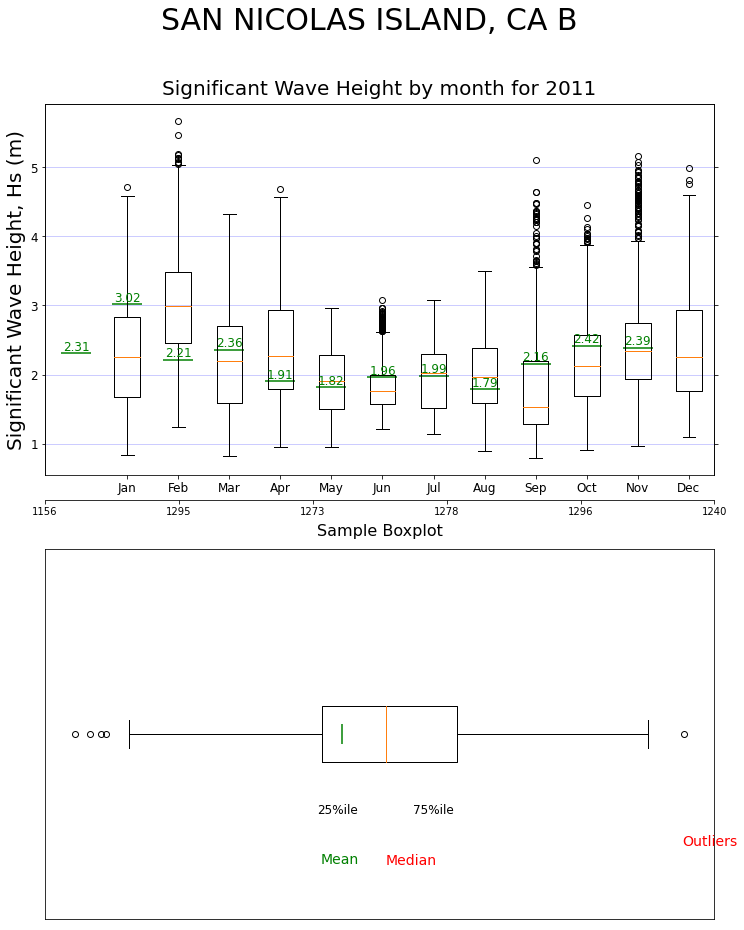

In [79]:
#  Create overall figure and specify size, and grid to specify positions of subplots
fig = plt.figure(figsize=(12,15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[5,1]) 


# Create a dataset for sample 'legend' boxplot, to go underneath actual boxplot
bp_sample2 = np.random.normal(2.5,0.5,500)


# Create two subplots - actual monthly-averaged data (top) and example 'legend' boxplot (bottom)

# Subplot of monthly-averaged boxplot data
bp = plt.subplot(211)
bp_data = bp.boxplot(box_data) # Add 'meanlineprops' to include the above-defined properties
bp.scatter(months,means,marker="_",color='g',linewidths=2.5,s=900) # Overlay monthly means as green lines using 'scatter' function.

# Subplot to show example 'legend' boxplot below actual monthly-averaged boxplot graph
bp2 = plt.subplot(212)
bp2_example = bp2.boxplot(bp_sample2,vert=False) # Plot horizontal example boxplot with labels
bp2.scatter(2.3,1,marker="|",color='g',linewidths=2.5,s=400)


# Add values of monthly means as text
for i, txt in enumerate(meansround):
    bp.annotate(txt, (months[i],means[i]),fontsize=12,horizontalalignment='center',verticalalignment='bottom',color='g')


# Get positions of Median, Quartiles and Outliers to use in 'legend' text labels 
for line in bp2_example['medians']:
    xm, ym = line.get_xydata()[0] # location of Median line   
for line in bp2_example['boxes']:
    xb, yb = line.get_xydata()[0] # location of Box edges (Quartiles)
for line in bp2_example['whiskers']:
    xw, yw = line.get_xydata()[0] # location of Whisker ends (Outliers)


# Add text labels for 'Median', Mean', '25th/75th %iles' and 'Outliers' to subplot2, to create sample 'legend' boxplot
bp2.annotate("Median",[xm,ym-0.3*ym],fontsize=14,color='r')
bp2.annotate("Mean",[2.2,0.65],fontsize=14,color='g')
bp2.annotate("25%ile",[xb-0.01*xb,yb-0.15*yb],fontsize=12)
bp2.annotate("75%ile",[xb+0.2*xb,yb-0.15*yb],fontsize=12)
bp2.annotate("Outliers",[xw+0.38*xw,yw-0.3*yw],fontsize=14,color='r')


# # Set colors of box aspects for top subplot    
pylab.setp(bp_data['boxes'], color='black')
pylab.setp(bp_data['whiskers'], color='black')
pylab.setp(bp_data['fliers'], color='r')


# Set colors of box aspects for bottom (sample) subplot   
pylab.setp(bp2_example['boxes'], color='black')
pylab.setp(bp2_example['whiskers'], color='black')
pylab.setp(bp2_example['fliers'], color='r')


# Set Titles
plt.suptitle(buoytitle, fontsize=30, y=0.97) # Overall plot title using 'buoytitle' variable
bp.set_title("Significant Wave Height by month for " + yeardate, fontsize=20, y=1.01) # Subtitle for top plot
bp2.set_title("Sample Boxplot", fontsize=16, y=1.02) # Subtitle for bottom plot


# Set axes labels and ticks
bp.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=12)
bp.set_ylabel('Significant Wave Height, Hs (m)', fontsize=20)
bp.tick_params(axis='y', which='major', labelsize=12, right='off')
bp.tick_params(axis='x', which='major', labelsize=12, top='off')


# Create a second row of x-axis labels for top subplot
newax = bp.twiny()
newax.xaxis.set_ticks_position('bottom')
newax.xaxis.set_label_position('bottom')
newax.spines['bottom'].set_position(('outward',25))
newax.set_xticklabels(monthlengths,fontsize=10)


# Plot horizontal gridlines onto top subplot
bp.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)


# # Remove tickmarks from bottom subplot
bp2.axes.get_xaxis().set_visible(False)
bp2.axes.get_yaxis().set_visible(False)